# **Exercise 2: Image Classification**

* PANAGIOTIS KAFANTARIS **p3352328**
* IOANNIS MICHALOPOULOS **p3352314**

## **X-Ray classification**

Given a study containing X-ray images, build a deep learning model that decides if the study is normal or abnormal. You must use at least 2 different architectures, one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and one with a popular pre-trained CNN model (e.g., VGG-19, ResNet, etc.). Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found at https://stanfordmlgroup.github.io/competitions/mura/. To download the dataset you must fill out a form, so complete this action as soon as possible.

## **INTRODUCTION:**

In this project, we developed a deep learning model to classify X-ray images as either normal or abnormal using the **MURA dataset**. Our goal was to explore different model architectures and training strategies to achieve high accuracy and robust performance across various body parts.

We experimented with both **custom Convolutional Neural Networks (CNNs)** and transfer learning using **DenseNet169**, comparing their effectiveness in capturing intricate patterns within X-ray images. The analysis focuses on evaluating model performance metrics such as accuracy, precision, recall, and F1-score, with special attention to how well the models generalize across different body parts.

Our findings demonstrate that transfer learning with **DenseNet169** significantly outperforms **custom-built CNNs**, achieving higher accuracy and better generalization, especially in challenging body parts like the **shoulder and humerus**. This study highlights the potential of leveraging pre-trained networks for medical image classification tasks, ultimately guiding future efforts in building robust and accurate diagnostic models.

## **SET UP**

*Import Necessary Libraries*

In [ ]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from google.colab import drive

*Mount Google Drive*

To access the dataset and store model outputs, we mount Google Drive. The dataset and model checkpoints will be stored in the MyDrive directory.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


*Define Base Paths*

We define the base path where the dataset and other related files are located.

In [ ]:
base_path = '/content/drive/MyDrive/'

We create a new directory named `dataset_csv` within our base path on Google Drive to store and load all the sets of data

In [ ]:
csv_dir = os.path.join(base_path, 'dataset_csv')
os.makedirs(csv_dir, exist_ok=True)

We create a new directory named `tfrecords_no_leaked_dataset_90_10_with_path` within our base path on Google Drive. This dedicated folder will store all the TFRecord files. We will talk further about TFRecord files later in the analysis.

In [ ]:
tfrecords_dir = os.path.join(base_path, 'tfrecords_no_leaked_dataset_90_10_with_path')
os.makedirs(tfrecords_dir, exist_ok=True)

Similarly for the models we are about to create

In [ ]:
models_dir = os.path.join(base_path, 'Ex2_Models')
os.makedirs(models_dir, exist_ok=True)

## **Data Loading and Preprocessing**

loading the dataset metadata, extracting image file paths and labels, and splitting the data into training, validation, and test sets. These steps are crucial for ensuring that the model receives the correct inputs and for evaluating its performance on unseen data.

We load the CSV files that contain the image file paths. Since the CSVs have no headers, we assign a column name ('path') manually. This enables us to easily reference the file paths in later processing steps.

In [ ]:
train_csv = base_path + 'MURA-v1.1/train_image_paths.csv'
valid_csv = base_path + 'MURA-v1.1/valid_image_paths.csv'

train_df = pd.read_csv(train_csv, header=None)
train_df.columns = ['path']

valid_df = pd.read_csv(valid_csv, header=None)
valid_df.columns = ['path']

print(f"\nNumber of training images: {len(train_df)}")
print(f"Number of validation images: {len(valid_df)}")


Number of training images: 36808
Number of validation images: 3197


In [ ]:
train_df.head()

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [ ]:
valid_df.head()

,path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


The labels (1 for positive and 0 for negative) are extracted directly from the file paths. If the string "positive" is found in the file path (case-insensitive), the image is labeled as 1, otherwise as 0. This is a simple heuristic to generate labels automatically.

In [ ]:
# Extract labels from the file path. For example, if 'positive' is in the path, set label=1, else label=0.
train_df['label'] = train_df['path'].apply(lambda x: 1 if 'positive' in x.lower() else 0)
valid_df['label'] = valid_df['path'].apply(lambda x: 1 if 'positive' in x.lower() else 0)

In [ ]:
train_df.head()

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1


## **SPLIT**

We split the original training data into a new training set and a test set using a 90/10 split. The test set is kept aside to evaluate the model's performance on unseen data. A fixed random_state ensures reproducibility of the split.

## **ENSURE NO LEAK**

Grouping by Patient and Study
To ensure that no single patient’s study appears in both training and test subsets, we extract two key pieces of information from each image path:

* Patient ID: Typically stored in a folder name such as "patient00001".
* Study ID: For example, "study1_positive" could be part of the file structure indicating a unique exam.

Both values are obtained by splitting the path string at slashes and choosing the correct indices. We then construct a group identifier ("group_id") by concatenating the patient ID and the study ID. This step is critical for grouping multiple images that belong to the same study before we perform our split.

## **Grouped Train/Test Split**
Instead of a standard random split (which could inadvertently assign different images from the same study to both training and test sets), we use GroupShuffleSplit from scikit-learn. This ensures each unique (patient, study) group resides exclusively in one subset. Specifically:

We set n_splits=1 to produce a single train/test division.
We reserve 90% of the group IDs for training and 10% for testing.
A fixed random_state (42) ensures reproducibility.
The resulting train indices and test indices allow us to build two new DataFrames.

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# 1) Extract patient and study information from the path
def extract_patient_study(path):
    parts = path.split('/')

    patient_id = parts[3]  # e.g., "patient00001"
    study_id   = parts[4]  # e.g., "study1_positive"
    return patient_id, study_id

train_df[['patient_id', 'study_id']] = train_df['path'].apply(
    lambda x: pd.Series(extract_patient_study(x))
)

# 2) Create a group identifier so each (patient, study) is a single group
train_df['group_id'] = train_df['patient_id'] + '_' + train_df['study_id']

# 3) Perform a grouped split
gss = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=42)
train_indices, test_indices = next(gss.split(train_df, groups=train_df['group_id']))

train_df_new = train_df.iloc[train_indices].reset_index(drop=True)
test_df_new  = train_df.iloc[test_indices].reset_index(drop=True)

Make sure there is no Overlap

In [ ]:
# Check there are no overlap in patient-study groups between splits
overlap = set(train_df_new['group_id']).intersection(set(test_df_new['group_id']))
print(f"Overlap in patient-study groups across train/test splits: {overlap}")  # should be empty

Overlap in patient-study groups across train/test splits: set()


Overlap its empty, which means there is no leak

In [ ]:
print("New train set size:", len(train_df_new))
print("New test set size:", len(test_df_new))
print("Validation set size:", len(valid_df))

New train set size: 33111
New test set size: 3697
Validation set size: 3197


In [ ]:
train_df_new[['path','label']].head()

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1


In [ ]:
test_df_new[['path','label']].head()

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00012/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00012/study...,1


In [ ]:
train_df = train_df_new
test_df = test_df_new

In [ ]:
print(f"\nNumber of training images (after split): {len(train_df)}")
print(f"Number of test images: {len(test_df)}")


Number of training images (after split): 33111
Number of test images: 3697


In [ ]:
test_df.head() # train_df has similar structure

,path,label,patient_id,study_id,group_id
0,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1,patient00008,study1_positive,patient00008_study1_positive
1,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1,patient00008,study1_positive,patient00008_study1_positive
2,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1,patient00008,study1_positive,patient00008_study1_positive
3,MURA-v1.1/train/XR_SHOULDER/patient00012/study...,1,patient00012,study1_positive,patient00012_study1_positive
4,MURA-v1.1/train/XR_SHOULDER/patient00012/study...,1,patient00012,study1_positive,patient00012_study1_positive


In [ ]:
from sklearn.utils import shuffle

train_df = shuffle(train_df, random_state=42)
valid_df = shuffle(valid_df, random_state=42)
test_df = shuffle(test_df, random_state=42)

Save the DataFrame to a CSV file within the folder

In [ ]:
train_df.to_csv(os.path.join(csv_dir, 'train_df.csv'), index=False)
valid_df.to_csv(os.path.join(csv_dir, 'valid_df.csv'), index=False)
test_df.to_csv(os.path.join(csv_dir, 'test_df.csv'), index=False)

Load the CSV files from Google Drive

In [ ]:
train_df = pd.read_csv(os.path.join(csv_dir, 'train_df.csv'))
valid_df = pd.read_csv(os.path.join(csv_dir, 'valid_df.csv'))
test_df = pd.read_csv(os.path.join(csv_dir, 'test_df.csv'))

In [ ]:
train_df.head()

,path,label,patient_id,study_id,group_id
0,MURA-v1.1/train/XR_WRIST/patient06594/study1_p...,1,patient06594,study1_positive,patient06594_study1_positive
1,MURA-v1.1/train/XR_FINGER/patient04082/study1_...,0,patient04082,study1_negative,patient04082_study1_negative
2,MURA-v1.1/train/XR_FOREARM/patient09627/study1...,0,patient09627,study1_negative,patient09627_study1_negative
3,MURA-v1.1/train/XR_SHOULDER/patient00321/study...,0,patient00321,study2_negative,patient00321_study2_negative
4,MURA-v1.1/train/XR_ELBOW/patient05820/study1_n...,0,patient05820,study1_negative,patient05820_study1_negative


## **TFRecord Conversion Pipeline**

This part of the code is designed to convert our image dataset into TFRecord files. TFRecords are a TensorFlow-native binary format that allow for efficient storage and rapid reading of large datasets. By splitting the dataset into several shards (smaller TFRecord files), we can speed up file I/O and enable parallel processing during training.

## **Helper Functions for TFRecord Features:**

These functions help convert raw data (image bytes and integer labels) into the format required for TFRecord features.
* `_bytes_feature`: Converts image data (as bytes) into a tf.train.Feature of type bytes.
* `_int64_feature`: Converts integer values (labels) into a tf.train.Feature of type int64.

The function `image_example` takes an image (as a byte string) and its corresponding label, wraps them into a dictionary of features, and returns a serialized tf.train.Example. Each example represents a single data point (one image and its label).

This function (`create_tfrecord_shard`) processes a chunk of the DataFrame (i.e., a shard) and writes each image–label pair to a TFRecord file. For each row, it constructs the full file path, reads the image as a byte string, converts it to a TFRecord example using image_example, and writes it to the TFRecord file.

`create_tfrecord_parallel` divides the entire DataFrame into `num_shards` smaller DataFrames (shards) and processes them in parallel using a `ThreadPoolExecutor`.
* `np.array_split` splits the DataFrame so that each shard has roughly an equal number of samples.
* A thread pool is used to execute `create_tfrecord_shard` concurrently, speeding up the conversion process.
* The function returns a list of generated TFRecord file paths.

In [ ]:
from tqdm import tqdm
import concurrent.futures

# Helper functions to create features for the TFRecord
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # convert EagerTensor to numpy
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, label, path):
    feature = {
        'image': _bytes_feature(image_string),
        'label': _int64_feature(label),
        'path':  _bytes_feature(path.encode('utf-8'))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Function to create a single shard TFRecord file from a DataFrame chunk
def create_tfrecord_shard(df_shard, shard_filename, base_path):
    with tf.io.TFRecordWriter(shard_filename) as writer:
        for idx, row in df_shard.iterrows():
            path = row['path']
            label = int(row['label'])
            full_path = os.path.join(base_path, path)
            try:
                with open(full_path, 'rb') as f:
                    image_string = f.read()
            except Exception as e:
                print(f"Error reading {full_path}: {e}")
                continue
            tf_example = image_example(image_string, label, path)
            writer.write(tf_example.SerializeToString())
    return shard_filename

# Function to create TFRecord shards in parallel
def create_tfrecord_parallel(df, tfrecord_file_prefix, base_path, num_shards=8):
    # Split the DataFrame into roughly equal shards
    df_shards = np.array_split(df, num_shards)
    shard_files = []
    # Use ThreadPoolExecutor to process shards in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_shards) as executor:
        futures = {
            executor.submit(create_tfrecord_shard, shard, f"{tfrecord_file_prefix}_shard_{i}.tfrecord", base_path): i
            for i, shard in enumerate(df_shards)
        }
        for future in tqdm(concurrent.futures.as_completed(futures), total=num_shards, desc="Creating TFRecord shards"):
            shard_file = future.result()
            shard_files.append(shard_file)
    return shard_files

By appending identifiers such as train, valid, and test to the tfrecords_dir path, we organize our TFRecord files into different groups. Later, when we create the shards, each file will be named using these prefixes (for example, train_shard_0.tfrecord, etc.).

In [ ]:
train_tfrecord_prefix = os.path.join(tfrecords_dir, 'train')
valid_tfrecord_prefix = os.path.join(tfrecords_dir, 'valid')
test_tfrecord_prefix  = os.path.join(tfrecords_dir, 'test')

## ***DONT RUN THESE CELLS***  (We put them inside comments to prevent accidental execution)

The dataset for each split is divided into several shards (16 for training, 8 for validation, and 8 for test), enabling parallel processing during conversion. Each shard is stored with a filename starting with the corresponding prefix.

In [ ]:
# valid_shard_files = create_tfrecord_parallel(valid_df, valid_tfrecord_prefix, base_path, num_shards=8)

In [ ]:
# test_shard_files  = create_tfrecord_parallel(test_df, test_tfrecord_prefix, base_path, num_shards=8)

In [ ]:
# train_shard_files = create_tfrecord_parallel(train_df, train_tfrecord_prefix, base_path, num_shards=16)

*** If these line execute then new shard files containing the dataset would be created an as a result we will have to re run the models again, something which takes a lot of time to finish. ***

Listing the TFRecord Files

In [ ]:
train_shard_files = tf.io.gfile.glob(os.path.join(tfrecords_dir, 'train_*.tfrecord'))
valid_shard_files = tf.io.gfile.glob(os.path.join(tfrecords_dir, 'valid_*.tfrecord'))
test_shard_files  = tf.io.gfile.glob(os.path.join(tfrecords_dir, 'test_*.tfrecord'))

# Print out the files to verify
print("Train TFRecord files:", train_shard_files)
print("Valid TFRecord files:", valid_shard_files)
print("Test TFRecord files:", test_shard_files)

Train TFRecord files: ['/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_0.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_9.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_1.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_3.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_5.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_4.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_6.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_2.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_8.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_dataset_90_10_with_path/train_shard_11.tfrecord', '/content/drive/MyDrive/tfrecords_no_leaked_da

## **Challenges and How They Are Addressed:**

#### * I/O Efficiency:
Converting thousands of small image files can be I/O-bound. By using TFRecord format and splitting the data into shards, we minimize the overhead and enable faster data reading during training.

#### * Parallel Processing:
The use of concurrent.futures.ThreadPoolExecutor leverages multiple CPU cores to convert shards concurrently, significantly reducing overall conversion time.

## **TFRecord Dataset Loading and Preprocessing**

We build an efficient input pipeline for training the model by reading pre-created TFRecord files. TFRecord is a binary format optimized for TensorFlow that allows for fast, parallel reading and preprocessing of large datasets.

What We Do:

1. Define the Image Size:
  * This sets a fixed resolution for all images, ensuring that each image is resized to 224×224 pixels before being fed into the model. Uniform image size is essential for batch processing and compatibility with model architectures.
2. Parsing Each TFRecord Example:
  * The _parse_function converts a serialized TFRecord (stored as a byte string) back into an image its corresponding label and its path (only if we have set `for_evaluation = True`).
  
    Key Steps:
        * Parsing: tf.io.parse_single_example reads the raw TFRecord and maps it to a dictionary according to our predefined feature description.
        * Decoding & Resizing: The image is decoded from JPEG format, resized to the target dimensions, and normalized so pixel values fall between 0 and 1.
        * Label Conversion: The label is cast to a float to be used during training.

3. Building the Data Pipeline with load_tfrecord_dataset:
  * This function creates a tf.data.Dataset from a list of TFRecord files and prepares it for training or evaluation.

    Key Steps:
      * Reading the TFRecord Files: tf.data.TFRecordDataset(tfrecord_files) reads the binary TFRecord files sequentially.
      * Mapping the Parser: The .map(_parse_function, ...) step applies the parser to each record in parallel (using tf.data.AUTOTUNE to automatically adjust the number of parallel calls).
      * Shuffling (Training Only): If the dataset is used for training (is_training=True), it is shuffled with a buffer size of 1000. Shuffling helps the model learn robust features by preventing it from seeing the data in a fixed order.
      * Batching & Prefetching: The dataset is batched into groups (of size 32 by default) and prefetched to overlap data preprocessing with model training, thereby maximizing GPU/CPU utilization.

In [ ]:
IMG_SIZE = (224, 224)

In [ ]:
def _parse_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_jpeg(parsed_example['image'], channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0

    label = tf.cast(parsed_example['label'], tf.float32)

    return image, label

def _parse_function_for_evaluation(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'path': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_jpeg(parsed_example['image'], channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0

    label = tf.cast(parsed_example['label'], tf.float32)
    path = parsed_example['path']  # Get the path
    return image, label, path

In [ ]:
def load_tfrecord_dataset(tfrecord_files, batch_size=32, shuffle_buffer=1000, is_training=True, for_evaluation=False):
    ds = tf.data.TFRecordDataset(tfrecord_files)
    # ds = ds.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if for_evaluation:
        ds = ds.map(_parse_function_for_evaluation, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.apply(tf.data.experimental.ignore_errors())
    if is_training:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

**Loading the Datasets:**

Each dataset is created by reading the corresponding list of TFRecord shard files. The training dataset is shuffled (for randomness) while the validation and test datasets are not (to maintain order during evaluation). All datasets are batched and prefetched, ensuring an efficient input pipeline.

***For evaluation*** files contains the path which is crucial later on to show how well the model went for each body part.

In [ ]:
batch_size = 32

train_ds = load_tfrecord_dataset(train_shard_files, batch_size=batch_size, shuffle_buffer=1000, is_training=True)
train_ds_for_evaluation  = load_tfrecord_dataset(train_shard_files,  batch_size=batch_size, shuffle_buffer=1000, is_training=False, for_evaluation=True)

valid_ds = load_tfrecord_dataset(valid_shard_files, batch_size=batch_size, shuffle_buffer=1000, is_training=False)
valid_ds_for_evaluation  = load_tfrecord_dataset(valid_shard_files,  batch_size=batch_size, shuffle_buffer=1000, is_training=False, for_evaluation=True)

test_ds  = load_tfrecord_dataset(test_shard_files,  batch_size=batch_size, shuffle_buffer=1000, is_training=False)
test_ds_for_evaluation  = load_tfrecord_dataset(test_shard_files,  batch_size=batch_size, shuffle_buffer=1000, is_training=False, for_evaluation=True)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


This preparation ensures that our model receives properly preprocessed data in a highly efficient manner, allowing for faster training and consistent evaluation on the test set.

## **Visualizing Data and Analyzing Label Distribution**

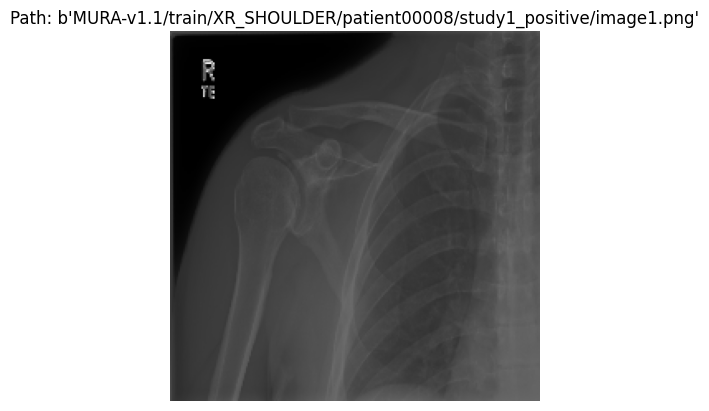

In [ ]:
for images, labels, paths in test_ds_for_evaluation.take(1):
    # Convert the first image from tensor to numpy array
    first_image = images[0].numpy()
    first_label = labels[0].numpy()
    first_path = paths[0].numpy()
    break

plt.imshow(first_image)
plt.title(f"Label: {first_label}")
plt.title(f"Path: {first_path}")
plt.axis('off')
plt.show()


Understanding the label distribution is essential for detecting any class imbalance, which could affect model training and performance.

In [ ]:
print("Training labels distribution:")
print(train_df['label'].value_counts())

print("\nValidation labels distribution:")
print(valid_df['label'].value_counts())

print("\nTest labels distribution:")
print(test_df['label'].value_counts())

Training labels distribution:
label
0    19802
1    13309
Name: count, dtype: int64

Validation labels distribution:
label
0    1667
1    1530
Name: count, dtype: int64

Test labels distribution:
label
0    2133
1    1564
Name: count, dtype: int64


***IMBALANCE***

Some imbalance between 0s and 1s exists in the trainig set and thats why we will compute weights such that the minority class gets higher weight.

## **Building and Training a Custom CNN Model**

we will build a custom Convolutional Neural Network (CNN) from scratch to classify X-ray images as normal or abnormal. We will also set up a training pipeline with useful callbacks and visualize the model performance.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight

**Building the Custom CNN Architecture**

We design a compact yet effective CNN architecture using convolutional, pooling, and dropout layers.
The model is structured as follows:

* Input Layer: Takes images of size (224, 224, 3).

* Conv2D + BatchNorm + MaxPooling + Dropout (Block 1): 128 filters with ReLU activation.

* Conv2D + BatchNorm + MaxPooling + Dropout (Block 2): 64 filters with ReLU activation.

* GlobalAveragePooling2D: Reduces the spatial dimensions to a single vector.

* Fully Connected Layer: Dense layer with 32 units and ReLU activation.

* Output Layer: A single unit with sigmoid activation for binary classification.

We experimented with data augmentation but the model performed way worse and as a result we abandonded the idea.

In [ ]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model


In [ ]:
custom_cnn_model = build_custom_cnn()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
custom_cnn_model.compile(optimizer=optimizer,
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
custom_cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,385 (314.00 KB)

 Trainable params: 79,937 (312.25 KB)

 Non-trainable params: 448 (1.75 KB)

Handling Class Imbalance with Class Weights

In [ ]:
train_labels = train_df['label'].values
class_weights_array = class_weight.compute_class_weight(class_weight='balanced',
                                                        classes=np.unique(train_labels),
                                                        y=train_labels)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8360519139480861), 1: np.float64(1.2439326771357728)}


**Setting Up Callbacks**

Callbacks help in monitoring and controlling the training process. We will use the following:

* EarlyStopping: Stops training when the validation accuracy plateaus.

* ReduceLROnPlateau: Reduces the learning rate when the validation loss plateaus.

* ModelCheckpoint: Saves the best model based on validation accuracy.

In [ ]:
# Define callbacks for training
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('custom_cnn_model_90_10.h5', save_best_only=True)

## ***DONT RUN THIS CELL***

**Training the Model**

We train the model on the training dataset and validate it on the validation dataset.

* We specify class weights to counter the imbalance in the dataset.

* The model will be trained for 20 epochs with callbacks to ensure optimal performance.

In [ ]:
epochs = 20
history_cnn_model = custom_cnn_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

Epoch 1/20
   1035/Unknown 199s 175ms/step - accuracy: 0.5483 - loss: 0.7189

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1035/1035 ━━━━━━━━━━━━━━━━━━━━ 228s 203ms/step - accuracy: 0.5483 - loss: 0.7189 - val_accuracy: 0.5239 - val_loss: 0.8146 - learning_rate: 0.0010
Epoch 2/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5682 - loss: 0.6840

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 94s 90ms/step - accuracy: 0.5682 - loss: 0.6840 - val_accuracy: 0.5371 - val_loss: 0.7498 - learning_rate: 0.0010
Epoch 3/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5773 - loss: 0.6734

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.5773 - loss: 0.6734 - val_accuracy: 0.5321 - val_loss: 0.7236 - learning_rate: 0.0010
Epoch 4/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5876 - loss: 0.6684

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.5876 - loss: 0.6684 - val_accuracy: 0.5327 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 5/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5871 - loss: 0.6668

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.5871 - loss: 0.6668 - val_accuracy: 0.5314 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 6/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5942 - loss: 0.6645

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.5942 - loss: 0.6645 - val_accuracy: 0.5765 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 7/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5902 - loss: 0.6615

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.5902 - loss: 0.6615 - val_accuracy: 0.5821 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 8/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.5959 - loss: 0.6603 - val_accuracy: 0.5427 - val_loss: 0.7084 - learning_rate: 0.0010
Epoch 9/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6044 - loss: 0.6557 - val_accuracy: 0.5142 - val_loss: 0.7827 - learning_rate: 0.0010
Epoch 10/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6194 - loss: 0.6443 - val_accuracy: 0.5637 - val_loss: 0.7251 - learning_rate: 5.0000e-04
Epoch 11/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6371 - loss: 0.6319 - val_accuracy: 0.5561 - val_loss: 0.7753 - learning_rate: 5.0000e-04
Epoch 12/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6451 - loss: 0.6226

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6451 - loss: 0.6226 - val_accuracy: 0.6193 - val_loss: 0.6466 - learning_rate: 2.5000e-04
Epoch 13/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6557 - loss: 0.6114

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6557 - loss: 0.6114 - val_accuracy: 0.6481 - val_loss: 0.6190 - learning_rate: 2.5000e-04
Epoch 14/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6605 - loss: 0.6098 - val_accuracy: 0.6275 - val_loss: 0.6429 - learning_rate: 2.5000e-04
Epoch 15/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6610 - loss: 0.6079

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6610 - loss: 0.6079 - val_accuracy: 0.6512 - val_loss: 0.6174 - learning_rate: 2.5000e-04
Epoch 16/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6677 - loss: 0.6051 - val_accuracy: 0.6528 - val_loss: 0.6236 - learning_rate: 2.5000e-04
Epoch 17/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6692 - loss: 0.6042

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6692 - loss: 0.6042 - val_accuracy: 0.6678 - val_loss: 0.6137 - learning_rate: 2.5000e-04
Epoch 18/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6737 - loss: 0.6003

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6737 - loss: 0.6003 - val_accuracy: 0.6634 - val_loss: 0.6091 - learning_rate: 2.5000e-04
Epoch 19/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6724 - loss: 0.6004 - val_accuracy: 0.6534 - val_loss: 0.6334 - learning_rate: 2.5000e-04
Epoch 20/20
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.6759 - loss: 0.5974 - val_accuracy: 0.6556 - val_loss: 0.6125 - learning_rate: 2.5000e-04


Visualizing Training Performance

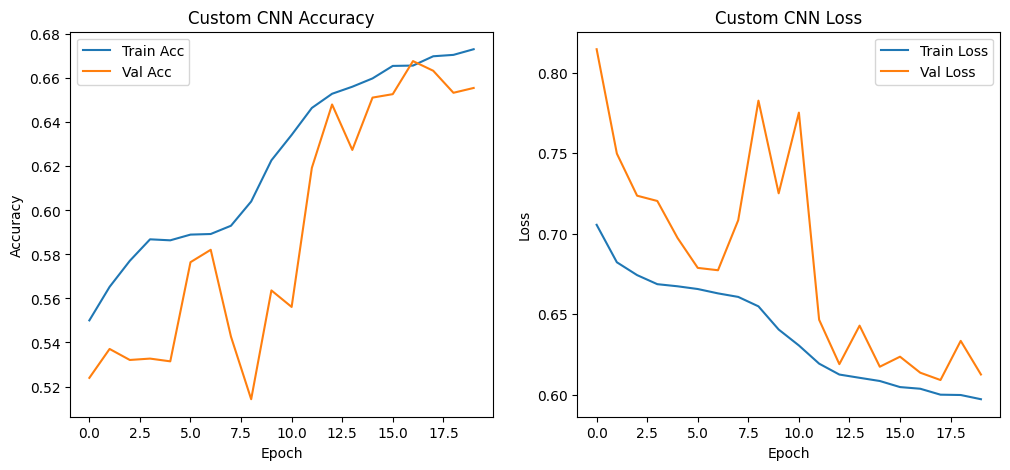

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_cnn_model.history['accuracy'], label='Train Acc')
plt.plot(history_cnn_model.history['val_accuracy'], label='Val Acc')
plt.title('Custom CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn_model.history['loss'], label='Train Loss')
plt.plot(history_cnn_model.history['val_loss'], label='Val Loss')
plt.title('Custom CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **Analysis On Results**

**Accuracy Plot Analysis:**

*Training Accuracy:*

* Shows a steady increase throughout the epochs.

* The consistent upward trend indicates that the model is effectively learning patterns from the training data.

*Validation Accuracy:*

* Fluctuates significantly during the initial epochs, indicating possible instability.

* However we notice that it starts to improve after the 14 epoch and this might be an indicator that if we increase the epochs we may see better results.

**Loss Plot Analysis:**

*Training Loss:*

* Decreases consistently, indicating that the model is minimizing the training error effectively.

* It shows the model is converging.

*Validation Loss:*

* Starts high and decreases initially but shows intermittent spikes and variability.

* However we notice that it starts to improve after the 12 epoch and this might be an indicator that if we increase the epochs we may see better results.

Save the model to Google Drive

In [ ]:
model_path = os.path.join(models_dir, 'custom_cnn_model_90_10.h5')

In [ ]:
custom_cnn_model.save(model_path)

Load the model from Google Drive

In [ ]:
custom_cnn_model = load_model(model_path)

Evaluate the loaded model on your test dataset

In [ ]:
test_loss, test_acc = custom_cnn_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.6233 - loss: 0.6416
Test Loss: 0.6029, Test Accuracy: 0.6749


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


**Predicting Test Data**

We define a function to generate predictions on the test dataset.

* The model outputs probabilities, which we convert to binary labels using a threshold of 0.5.

* We also collect the true labels from the dataset for comparison.

In [ ]:
def get_predictions(ds, model):
    predictions = model.predict(ds)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    true_labels = []
    for images, labels in ds:
        true_labels.extend(labels.numpy())
    true_labels = np.array(true_labels)

    return predictions, predicted_labels, true_labels

In [ ]:
predictions, true_labels, predicted_labels = get_predictions(test_ds, custom_cnn_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Plot the confusion matrix and classification report

In [ ]:
def plot_confusion_matrix_classification_report(true_labels, predicted_labels):

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.show()

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

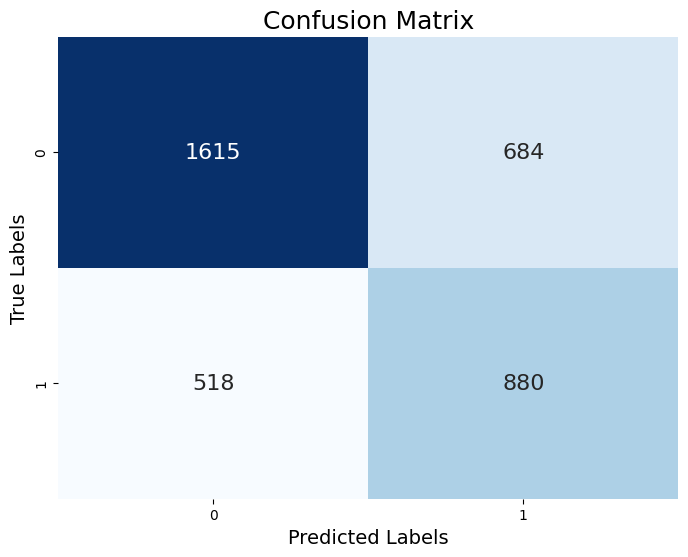


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      2299
           1       0.56      0.63      0.59      1398

    accuracy                           0.67      3697
   macro avg       0.66      0.67      0.66      3697
weighted avg       0.68      0.67      0.68      3697



In [ ]:
plot_confusion_matrix_classification_report(true_labels, predicted_labels)

## **Confusion Matrix Analysis**

* True Positives (TP): 880 (Correctly predicted abnormal cases)
* True Negatives (TN): 1615 (Correctly predicted normal cases)
* False Positives (FP): 684 (Incorrectly predicted as abnormal)
* False Negatives (FN): 518 (Incorrectly predicted as normal)

## **Key Observations:**

**Overall Accuracy:**

* The overall accuracy of the model is 67%, which is moderate.

* This indicates that the model correctly classifies around two-thirds of the test samples.

**Precision and Recall Imbalance:**

* Precision for normal (0) class: 0.76 (76% of predicted normal cases are actually normal).

* Precision for abnormal (1) class: 0.56 (56% of predicted abnormal cases are actually abnormal).

* This indicates that the model is more confident when predicting normal cases compared to abnormal cases.

* Recall for normal (0) class: 0.70 (70% of actual normal cases are correctly predicted).

* Recall for abnormal (1) class: 0.63 (63% of actual abnormal cases are correctly predicted).

* The model has better recall for abnormal cases compared to precision, which means it is trying to capture abnormalities even if it results in more false positives.

**F1-Score Analysis:**

* The F1-Score is 0.73 for normal cases and 0.59 for abnormal cases.

* The F1-score for abnormal cases is relatively low, indicating that the model struggles to balance precision and recall for the positive class.

**Class Imbalance Effect:**

* The support values indicate that normal cases (2299) are significantly more than abnormal cases (1398).

* Even with class balancing during training, the model tends to favor the majority class (normal).

## **Performance Analysis by Body Part**

*Why Body Part Analysis Matters:*

* X-ray images from different body parts may have varying levels of complexity and features.

* Identifying which body parts the model struggles with can guide targeted improvements.

**Extracting Predictions by Body Part**

We define a function to extract predictions and labels for each body part from the test dataset.

In [ ]:
from collections import defaultdict
import re
from tqdm import tqdm

def get_body_part_results(ds, model):
    body_part_results = defaultdict(lambda: {'labels': [], 'predictions': []})

    # Convert the dataset into a list to get the total length
    dataset = list(ds)

    # Create a single progress bar for the entire dataset
    with tqdm(total=len(dataset), desc="Processing Batches", unit="batch", dynamic_ncols=True, leave=True) as pbar:
        for batch in dataset:
            images, labels, paths = batch

            predictions = model.predict(images)
            predicted_labels = (predictions > 0.5).astype(int).flatten()

            true_labels = labels.numpy()

            for i in range(len(paths)):
                path = paths[i].numpy().decode('utf-8')
                label = true_labels[i]
                prediction = predicted_labels[i]

                # Extract body part using regex
                match = re.search(r'XR_(\w+)', path)
                if match:
                    body_part = match.group(1)
                else:
                    body_part = "UNKNOWN"

                body_part_results[body_part]['labels'].append(label)
                body_part_results[body_part]['predictions'].append(prediction)

            # Update progress bar after processing each batch
            pbar.update(1)

    return body_part_results

In [ ]:
body_part_results = get_body_part_results(test_ds_for_evaluation, custom_cnn_model)

Processing Batches:   0%|          | 0/116 [00:00<?, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:   1%|          | 1/116 [00:03<06:16,  3.28s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:   2%|▏         | 2/116 [00:07<06:55,  3.64s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:   3%|▎         | 3/116 [00:10<06:42,  3.56s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Processing Batches:   3%|▎         | 4/116 [00:17<09:06,  4.88s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Processing Batches:   4%|▍         | 5/116 [00:23<10:04,  5.44s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:   5%|▌         | 6/116 [00:27<08:55,  4.87s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:   6%|▌         | 7/116 [00:32<09:02,  4.98s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:   7%|▋         | 8/116 [00:36<08:19,  4.62s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:   8%|▊         | 9/116 [00:39<07:15,  4.07s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:   9%|▊         | 10/116 [00:42<06:23,  3.62s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:   9%|▉         | 11/116 [00:44<05:47,  3.31s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  10%|█         | 12/116 [00:47<05:21,  3.09s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  11%|█         | 13/116 [00:51<05:57,  3.47s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  12%|█▏        | 14/116 [00:55<06:02,  3.56s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  13%|█▎        | 15/116 [00:58<05:34,  3.31s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  14%|█▍        | 16/116 [01:00<05:10,  3.10s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  15%|█▍        | 17/116 [01:06<06:08,  3.72s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  16%|█▌        | 18/116 [01:08<05:25,  3.32s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  16%|█▋        | 19/116 [01:10<04:55,  3.04s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  17%|█▋        | 20/116 [01:13<04:33,  2.85s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  18%|█▊        | 21/116 [01:15<04:23,  2.78s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  19%|█▉        | 22/116 [01:21<05:29,  3.50s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  20%|█▉        | 23/116 [01:23<04:54,  3.17s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  21%|██        | 24/116 [01:26<04:36,  3.01s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  22%|██▏       | 25/116 [01:31<05:32,  3.65s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  22%|██▏       | 26/116 [01:36<06:10,  4.12s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  23%|██▎       | 27/116 [01:39<05:26,  3.66s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  24%|██▍       | 28/116 [01:41<04:54,  3.35s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  25%|██▌       | 29/116 [01:44<04:40,  3.23s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  26%|██▌       | 30/116 [01:48<04:51,  3.39s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  27%|██▋       | 31/116 [01:50<04:27,  3.15s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  28%|██▊       | 32/116 [01:53<04:10,  2.99s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  28%|██▊       | 33/116 [01:56<03:58,  2.87s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  29%|██▉       | 34/116 [01:58<03:49,  2.79s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  30%|███       | 35/116 [02:03<04:44,  3.51s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  31%|███       | 36/116 [02:06<04:19,  3.24s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  32%|███▏      | 37/116 [02:08<03:56,  2.99s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  33%|███▎      | 38/116 [02:11<03:39,  2.81s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  34%|███▎      | 39/116 [02:14<03:40,  2.86s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  34%|███▍      | 40/116 [02:19<04:31,  3.57s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  35%|███▌      | 41/116 [02:21<04:01,  3.22s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  36%|███▌      | 42/116 [02:24<03:40,  2.98s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  37%|███▋      | 43/116 [02:26<03:24,  2.80s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  38%|███▊      | 44/116 [02:31<04:12,  3.51s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  39%|███▉      | 45/116 [02:34<03:50,  3.24s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  40%|███▉      | 46/116 [02:36<03:29,  2.99s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  41%|████      | 47/116 [02:39<03:13,  2.81s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  41%|████▏     | 48/116 [02:41<03:07,  2.75s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  42%|████▏     | 49/116 [02:45<03:29,  3.12s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  43%|████▎     | 50/116 [02:48<03:16,  2.97s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  44%|████▍     | 51/116 [02:50<03:02,  2.80s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  45%|████▍     | 52/116 [02:53<02:51,  2.68s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  46%|████▌     | 53/116 [02:55<02:43,  2.59s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  47%|████▋     | 54/116 [02:59<03:00,  2.91s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  47%|████▋     | 55/116 [03:02<02:59,  2.95s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  48%|████▊     | 56/116 [03:05<02:50,  2.85s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  49%|████▉     | 57/116 [03:07<02:43,  2.77s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  50%|█████     | 58/116 [03:12<03:22,  3.50s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  51%|█████     | 59/116 [03:18<03:48,  4.01s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  52%|█████▏    | 60/116 [03:20<03:20,  3.58s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  53%|█████▎    | 61/116 [03:23<02:57,  3.22s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  53%|█████▎    | 62/116 [03:25<02:44,  3.04s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  54%|█████▍    | 63/116 [03:30<03:15,  3.69s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  55%|█████▌    | 64/116 [03:33<02:54,  3.36s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  56%|█████▌    | 65/116 [03:35<02:36,  3.08s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  57%|█████▋    | 66/116 [03:38<02:23,  2.87s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  58%|█████▊    | 67/116 [03:41<02:23,  2.92s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  59%|█████▊    | 68/116 [03:46<02:52,  3.60s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  59%|█████▉    | 69/116 [03:48<02:32,  3.24s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  60%|██████    | 70/116 [03:51<02:17,  2.99s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  61%|██████    | 71/116 [03:53<02:09,  2.88s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  62%|██████▏   | 72/116 [03:59<02:36,  3.56s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  63%|██████▎   | 73/116 [04:01<02:17,  3.21s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  64%|██████▍   | 74/116 [04:03<02:04,  2.96s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  65%|██████▍   | 75/116 [04:06<01:57,  2.86s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  66%|██████▌   | 76/116 [04:09<01:51,  2.79s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  66%|██████▋   | 77/116 [04:14<02:16,  3.51s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  67%|██████▋   | 78/116 [04:16<02:03,  3.24s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  68%|██████▊   | 79/116 [04:19<01:50,  2.98s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  69%|██████▉   | 80/116 [04:21<01:40,  2.80s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  70%|██████▉   | 81/116 [04:24<01:40,  2.87s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  71%|███████   | 82/116 [04:28<01:45,  3.11s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  72%|███████▏  | 83/116 [04:30<01:35,  2.89s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  72%|███████▏  | 84/116 [04:33<01:29,  2.81s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  73%|███████▎  | 85/116 [04:35<01:23,  2.69s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  74%|███████▍  | 86/116 [04:38<01:19,  2.67s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  75%|███████▌  | 87/116 [04:42<01:28,  3.06s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  76%|███████▌  | 88/116 [04:44<01:22,  2.94s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  77%|███████▋  | 89/116 [04:47<01:14,  2.77s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  78%|███████▊  | 90/116 [04:49<01:10,  2.72s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  78%|███████▊  | 91/116 [04:53<01:12,  2.89s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  79%|███████▉  | 92/116 [04:57<01:18,  3.27s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  80%|████████  | 93/116 [04:59<01:10,  3.06s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  81%|████████  | 94/116 [05:02<01:04,  2.92s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  82%|████████▏ | 95/116 [05:05<00:59,  2.83s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  83%|████████▎ | 96/116 [05:07<00:55,  2.76s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  84%|████████▎ | 97/116 [05:12<01:06,  3.49s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  84%|████████▍ | 98/116 [05:15<00:57,  3.18s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  85%|████████▌ | 99/116 [05:18<00:51,  3.01s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  86%|████████▌ | 100/116 [05:23<00:58,  3.66s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  87%|████████▋ | 101/116 [05:26<00:54,  3.62s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  88%|████████▊ | 102/116 [05:29<00:45,  3.25s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  89%|████████▉ | 103/116 [05:31<00:38,  2.99s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  90%|████████▉ | 104/116 [05:34<00:34,  2.88s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  91%|█████████ | 105/116 [05:39<00:39,  3.57s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  91%|█████████▏| 106/116 [05:41<00:32,  3.28s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  92%|█████████▏| 107/116 [05:44<00:27,  3.02s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  93%|█████████▎| 108/116 [05:46<00:22,  2.85s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing Batches:  94%|█████████▍| 109/116 [05:49<00:19,  2.78s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  95%|█████████▍| 110/116 [05:53<00:18,  3.15s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  96%|█████████▌| 111/116 [05:56<00:15,  3.00s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  97%|█████████▋| 112/116 [05:58<00:11,  2.88s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  97%|█████████▋| 113/116 [06:01<00:08,  2.80s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing Batches:  98%|█████████▊| 114/116 [06:03<00:05,  2.74s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Batches:  99%|█████████▉| 115/116 [06:09<00:03,  3.48s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Processing Batches: 100%|██████████| 116/116 [06:11<00:00,  3.20s/batch]


**Printing Performance Metrics for Each Body Part**

In [ ]:
from sklearn.metrics import accuracy_score

def print_body_parts(body_part_results):
  # Calculate and print metrics for each body part
  for body_part, data in body_part_results.items():
      y_true = data['labels']
      y_pred = data['predictions']
      accuracy = accuracy_score(y_true, y_pred)
      report = classification_report(y_true, y_pred, zero_division=0)
      print(f"\nBody Part: {body_part}")
      print(f"Accuracy: {accuracy * 100:.2f}%")
      print("Classification Report:")
      print(report)

In [ ]:
print_body_parts(body_part_results)


Body Part: SHOULDER
Accuracy: 62.20%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.72      0.66       467
         1.0       0.64      0.52      0.57       443

    accuracy                           0.62       910
   macro avg       0.62      0.62      0.62       910
weighted avg       0.62      0.62      0.62       910


Body Part: HUMERUS
Accuracy: 61.24%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.72      0.67        71
         1.0       0.58      0.48      0.53        58

    accuracy                           0.61       129
   macro avg       0.61      0.60      0.60       129
weighted avg       0.61      0.61      0.61       129


Body Part: FINGER
Accuracy: 70.98%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75       277
         1.0       0.66      0.63      0.65       202

  

## **Analysis of Body Part-wise Model Performance**

**Key Observations and Insights:**

*Best Performing Body Parts:*

* HAND: Highest accuracy at 75.36%, with excellent precision (0.81) and recall (0.85) for the normal class.

* FINGER: Achieves 70.98% accuracy with balanced precision and recall.

* FOREARM: Accuracy of 71.51% with good precision (0.82) for the positive class, but recall is relatively lower (0.51).

* These body parts may have more distinguishable patterns or clearer demarcation between normal and abnormal cases.

*Moderate Performing Body Parts:*

* ELBOW (69.18%) and WRIST (65.48%) show moderate accuracy, likely due to their complex bone structures that introduce classification ambiguity.

* Precision and recall show notable differences between classes, indicating that the model struggles more with abnormalities.

*Worst Performing Body Parts:*

* SHOULDER (62.20%) and HUMERUS (61.24%) show the lowest accuracy among all body parts.

* These regions might have more complex anatomical structures or less distinguishable abnormalities.

* Recall for positive classes (abnormal) is significantly lower (0.52 for Shoulder, 0.48 for Humerus), indicating that many abnormal cases are being misclassified as normal.



## **Custom CNN Model Version 2 (V2): Enhanced Architecture and Training**

To improve the model's performance, especially on underperforming body parts, we introduce an upgraded CNN architecture (V2). The goal is to increase model capacity while maintaining generalization.

**Architectural Enhancements**

*High Capacity Blocks:*

* Increased the model's capacity by stacking convolutional layers with 128 filters in the initial two blocks.

* Each block has two convolutional layers followed by batch normalization, max pooling, and dropout.

* The increased number of filters allows the model to learn more complex features.

*Feature Reduction Block:*

* A reduction block with 64 filters to gradually decrease feature complexity.

* This is important for better generalization and reducing overfitting.

*Global Average Pooling:*

* Reduces the spatial dimensions to a single vector without losing spatial information.

*Enhanced Dense Layer:*

* Added a 64-unit dense layer with dropout for better regularization.

*Again Data Augmentation did not provide better results*

In [ ]:
def build_cnn_custom_model_v2(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Block 1: High capacity block with 128 filters repeated twice
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    # Block 2: Additional block with 128 filters repeated twice
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    # Block 3: Reduction block with 64 filters repeated twice
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    # Global pooling to collapse spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers for final classification
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Build and compile the model
custom_cnn_model_v2 = build_cnn_custom_model_v2()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
custom_cnn_model_v2.compile(optimizer=optimizer,
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
custom_cnn_model_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 564,097 (2.15 MB)

 Trainable params: 562,689 (2.15 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
# Define callbacks for training
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('custom_cnn_model_v2_90_10.h5', save_best_only=True)

## ***DONT RUN THIS CELL***

Due to low GPU usage limits, we could not train our model for longer.

In [ ]:
epochs = 10
history_cnn_model_v2 = custom_cnn_model_v2.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/10
   1035/Unknown 334s 291ms/step - accuracy: 0.5633 - loss: 0.7265

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1035/1035 ━━━━━━━━━━━━━━━━━━━━ 358s 314ms/step - accuracy: 0.5633 - loss: 0.7265 - val_accuracy: 0.5624 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 2/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5962 - loss: 0.6669

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 277ms/step - accuracy: 0.5962 - loss: 0.6669 - val_accuracy: 0.5862 - val_loss: 0.6858 - learning_rate: 0.0010
Epoch 3/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 278ms/step - accuracy: 0.6107 - loss: 0.6560 - val_accuracy: 0.5724 - val_loss: 0.7200 - learning_rate: 0.0010
Epoch 4/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 287s 277ms/step - accuracy: 0.6108 - loss: 0.6502 - val_accuracy: 0.5565 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 5/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 278ms/step - accuracy: 0.6349 - loss: 0.6367 - val_accuracy: 0.5439 - val_loss: 0.7583 - learning_rate: 5.0000e-04
Epoch 6/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6473 - loss: 0.6257

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 278ms/step - accuracy: 0.6473 - loss: 0.6257 - val_accuracy: 0.5862 - val_loss: 0.6813 - learning_rate: 5.0000e-04
Epoch 7/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6646 - loss: 0.6098

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 278ms/step - accuracy: 0.6646 - loss: 0.6098 - val_accuracy: 0.6128 - val_loss: 0.6689 - learning_rate: 5.0000e-04
Epoch 8/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6789 - loss: 0.5949

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 278ms/step - accuracy: 0.6789 - loss: 0.5949 - val_accuracy: 0.6444 - val_loss: 0.6403 - learning_rate: 5.0000e-04
Epoch 9/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6982 - loss: 0.5766

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 278ms/step - accuracy: 0.6982 - loss: 0.5766 - val_accuracy: 0.6193 - val_loss: 0.6388 - learning_rate: 5.0000e-04
Epoch 10/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 288s 278ms/step - accuracy: 0.7093 - loss: 0.5634 - val_accuracy: 0.5996 - val_loss: 0.6753 - learning_rate: 5.0000e-04


In [ ]:
# Evaluate on the test set
test_loss, test_acc = custom_cnn_model_v2.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.6554 - loss: 0.6191
Test Accuracy: 0.6673


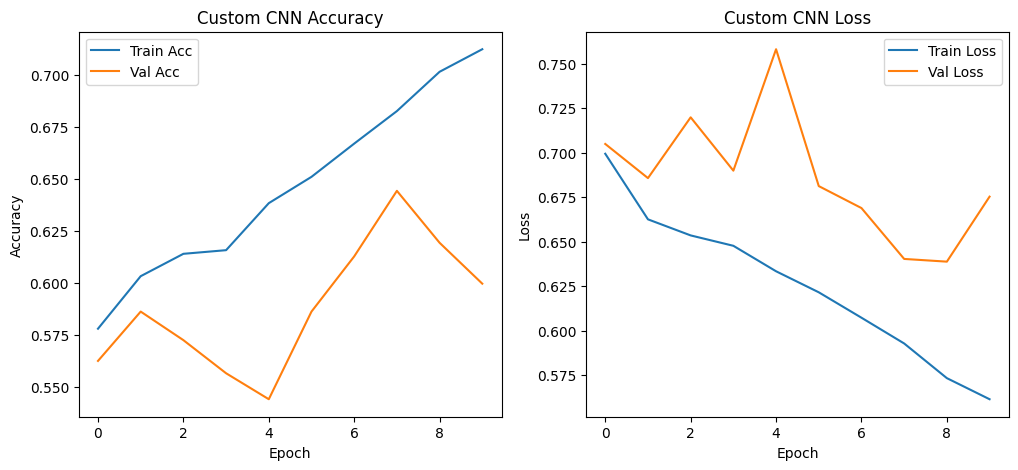

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_cnn_model_v2.history['accuracy'], label='Train Acc')
plt.plot(history_cnn_model_v2.history['val_accuracy'], label='Val Acc')
plt.title('Custom CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn_model_v2.history['loss'], label='Train Loss')
plt.plot(history_cnn_model_v2.history['val_loss'], label='Val Loss')
plt.title('Custom CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Analysis of Training Results for Custom CNN Model V2**

**Accuracy Plot Analysis:**

*Training Accuracy:*

* The training accuracy shows a steady upward trend by the end of the 10th epoch.

* This indicates that the model is learning effectively from the training data without significant issues of underfitting.

*Validation Accuracy:*

* The validation accuracy is comparatively lower but shows an upward trend after an initial drop.

* Reaches around 0.63 by the end of the training, which is an improvement over the previous version.

* The gap between training and validation accuracy has reduced compared to the previous model, suggesting that overfitting has been mitigated to some extent.

**Key Observations:**

* The gap between training and validation accuracy is narrower compared to the previous model.

* This indicates that the modifications made (additional convolutional blocks, increased capacity, and dropout) have effectively balanced the model's capacity and generalization.

* We reached these results with only 10 epochs. It is obvious that if we increase the epochs then its certain that we will witness better results.



Save and load the model to Google Drive

In [ ]:
model_path = os.path.join(models_dir, 'custom_cnn_model_v2_90_10.h5')

In [ ]:
custom_cnn_model_v2.save(model_path)

In [ ]:
custom_cnn_model_v2 = load_model(model_path)

In [ ]:
# evaluate the loaded model on your test dataset
test_loss, test_acc = custom_cnn_model_v2.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 213ms/step - accuracy: 0.6023 - loss: 0.6815
Test Loss: 0.6587, Test Accuracy: 0.6089


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
predictions, true_labels, predicted_labels = get_predictions(test_ds, custom_cnn_model_v2)

116/116 ━━━━━━━━━━━━━━━━━━━━ 2034s 17s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


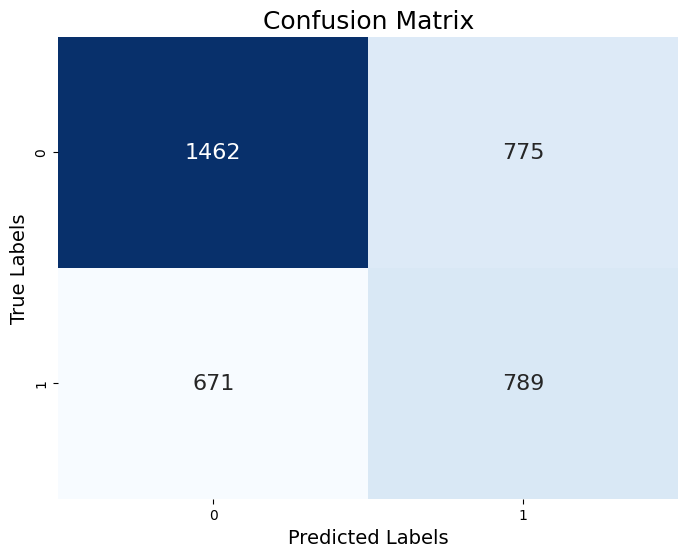


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      2237
           1       0.50      0.54      0.52      1460

    accuracy                           0.61      3697
   macro avg       0.59      0.60      0.60      3697
weighted avg       0.61      0.61      0.61      3697



In [ ]:
plot_confusion_matrix_classification_report(true_labels, predicted_labels)

## **Evaluation of Custom CNN Model V2 on Test Dataset**

* True Positives (TP): 789 (Correctly predicted abnormal cases)
* True Negatives (TN): 1462 (Correctly predicted normal cases)
* False Positives (FP): 775 (Normal cases predicted as abnormal)
* False Negatives (FN): 671 (Abnormal cases predicted as normal)

**Key Observations:**

*Accuracy:*

* The overall accuracy is 61%, which is slightly lower than the training and validation accuracies.

*Precision:*

* Class 0 (Normal): 0.69 - The model correctly identifies 69% of predicted normal cases.

* Class 1 (Abnormal): 0.50 - The model correctly identifies 50% of predicted abnormal cases.

This shows that the model tends to overpredict normal cases more than abnormal ones.

*Recall:*

* Class 0 (Normal): 0.65 - The model correctly identifies 65% of actual normal cases.

* Class 1 (Abnormal): 0.54 - The model correctly identifies 54% of actual abnormal cases.

The relatively low recall for abnormalities indicates that many abnormal cases are misclassified as normal, leading to false negatives.

*F1-Score:*

* Class 0 (Normal): 0.67 - Fairly balanced between precision and recall.

* Class 1 (Abnormal): 0.52 - Lower F1-score due to both low precision and recall.

The macro average F1-score of 0.60 indicates that the model struggles to balance both classes equally.

In [ ]:
body_part_results = get_body_part_results(test_ds_for_evaluation, custom_cnn_model_v2)

Processing Batches:   0%|          | 0/116 [00:00<?, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


Processing Batches:   1%|          | 1/116 [00:11<22:05, 11.53s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Processing Batches:   2%|▏         | 2/116 [00:11<09:15,  4.87s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Processing Batches:   3%|▎         | 3/116 [00:12<05:17,  2.81s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:   3%|▎         | 4/116 [00:12<03:20,  1.79s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Processing Batches:   4%|▍         | 5/116 [00:12<02:16,  1.23s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Processing Batches:   5%|▌         | 6/116 [00:12<01:36,  1.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:   6%|▌         | 7/116 [00:12<01:12,  1.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:   7%|▋         | 8/116 [00:13<00:56,  1.92batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:   8%|▊         | 9/116 [00:13<00:45,  2.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:   9%|▊         | 10/116 [00:13<00:38,  2.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:   9%|▉         | 11/116 [00:13<00:33,  3.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:  10%|█         | 12/116 [00:14<00:29,  3.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  11%|█         | 13/116 [00:14<00:27,  3.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  12%|█▏        | 14/116 [00:14<00:29,  3.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  13%|█▎        | 15/116 [00:14<00:27,  3.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Processing Batches:  14%|█▍        | 16/116 [00:15<00:29,  3.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Processing Batches:  15%|█▍        | 17/116 [00:15<00:26,  3.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  16%|█▌        | 18/116 [00:15<00:24,  3.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Batches:  16%|█▋        | 19/116 [00:15<00:23,  4.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Batches:  17%|█▋        | 20/116 [00:16<00:22,  4.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Processing Batches:  18%|█▊        | 21/116 [00:16<00:21,  4.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  19%|█▉        | 22/116 [00:16<00:24,  3.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Processing Batches:  20%|█▉        | 23/116 [00:16<00:27,  3.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Processing Batches:  21%|██        | 24/116 [00:17<00:28,  3.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Batches:  22%|██▏       | 25/116 [00:17<00:25,  3.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  22%|██▏       | 26/116 [00:17<00:23,  3.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  23%|██▎       | 27/116 [00:17<00:21,  4.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Batches:  24%|██▍       | 28/116 [00:18<00:20,  4.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Processing Batches:  25%|██▌       | 29/116 [00:18<00:19,  4.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  26%|██▌       | 30/116 [00:18<00:23,  3.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  27%|██▋       | 31/116 [00:18<00:21,  3.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Batches:  28%|██▊       | 32/116 [00:19<00:20,  4.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Processing Batches:  28%|██▊       | 33/116 [00:19<00:19,  4.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:  29%|██▉       | 34/116 [00:19<00:18,  4.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  30%|███       | 35/116 [00:19<00:21,  3.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Batches:  31%|███       | 36/116 [00:20<00:23,  3.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Processing Batches:  32%|███▏      | 37/116 [00:20<00:25,  3.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Processing Batches:  33%|███▎      | 38/116 [00:21<00:26,  2.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Batches:  34%|███▎      | 39/116 [00:21<00:27,  2.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Processing Batches:  34%|███▍      | 40/116 [00:21<00:27,  2.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Processing Batches:  35%|███▌      | 41/116 [00:22<00:27,  2.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Batches:  36%|███▌      | 42/116 [00:22<00:27,  2.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Processing Batches:  37%|███▋      | 43/116 [00:22<00:24,  2.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:  38%|███▊      | 44/116 [00:23<00:21,  3.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Processing Batches:  39%|███▉      | 45/116 [00:23<00:22,  3.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  40%|███▉      | 46/116 [00:23<00:19,  3.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Processing Batches:  41%|████      | 47/116 [00:23<00:18,  3.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:  41%|████▏     | 48/116 [00:24<00:19,  3.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  42%|████▏     | 49/116 [00:24<00:20,  3.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  43%|████▎     | 50/116 [00:24<00:21,  3.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  44%|████▍     | 51/116 [00:25<00:18,  3.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  45%|████▍     | 52/116 [00:25<00:20,  3.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:  46%|████▌     | 53/116 [00:25<00:20,  3.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  47%|████▋     | 54/116 [00:26<00:20,  2.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  47%|████▋     | 55/116 [00:26<00:21,  2.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  48%|████▊     | 56/116 [00:26<00:18,  3.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  49%|████▉     | 57/116 [00:27<00:16,  3.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  50%|█████     | 58/116 [00:27<00:17,  3.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Processing Batches:  51%|█████     | 59/116 [00:27<00:15,  3.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  52%|█████▏    | 60/116 [00:27<00:14,  3.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Processing Batches:  53%|█████▎    | 61/116 [00:28<00:13,  4.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  53%|█████▎    | 62/116 [00:28<00:12,  4.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Processing Batches:  54%|█████▍    | 63/116 [00:28<00:14,  3.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Batches:  55%|█████▌    | 64/116 [00:28<00:13,  3.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  56%|█████▌    | 65/116 [00:29<00:12,  4.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  57%|█████▋    | 66/116 [00:29<00:14,  3.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Processing Batches:  58%|█████▊    | 67/116 [00:29<00:13,  3.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Batches:  59%|█████▊    | 68/116 [00:30<00:14,  3.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  59%|█████▉    | 69/116 [00:30<00:12,  3.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  60%|██████    | 70/116 [00:30<00:13,  3.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  61%|██████    | 71/116 [00:30<00:12,  3.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  62%|██████▏   | 72/116 [00:31<00:13,  3.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Processing Batches:  63%|██████▎   | 73/116 [00:31<00:12,  3.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Processing Batches:  64%|██████▍   | 74/116 [00:31<00:11,  3.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Batches:  65%|██████▍   | 75/116 [00:31<00:10,  3.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Processing Batches:  66%|██████▌   | 76/116 [00:32<00:11,  3.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  66%|██████▋   | 77/116 [00:32<00:10,  3.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Processing Batches:  67%|██████▋   | 78/116 [00:32<00:11,  3.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Processing Batches:  68%|██████▊   | 79/116 [00:33<00:10,  3.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Batches:  69%|██████▉   | 80/116 [00:33<00:11,  3.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Batches:  70%|██████▉   | 81/116 [00:33<00:12,  2.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Batches:  71%|███████   | 82/116 [00:34<00:10,  3.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Batches:  72%|███████▏  | 83/116 [00:34<00:10,  3.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processing Batches:  72%|███████▏  | 84/116 [00:34<00:10,  2.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Batches:  73%|███████▎  | 85/116 [00:35<00:11,  2.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Batches:  74%|███████▍  | 86/116 [00:35<00:09,  3.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Batches:  75%|███████▌  | 87/116 [00:35<00:08,  3.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Processing Batches:  76%|███████▌  | 88/116 [00:36<00:09,  2.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Processing Batches:  77%|███████▋  | 89/116 [00:36<00:08,  3.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  78%|███████▊  | 90/116 [00:36<00:08,  3.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  78%|███████▊  | 91/116 [00:36<00:07,  3.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Processing Batches:  79%|███████▉  | 92/116 [00:37<00:07,  3.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Processing Batches:  80%|████████  | 93/116 [00:37<00:06,  3.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Processing Batches:  81%|████████  | 94/116 [00:37<00:06,  3.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Processing Batches:  82%|████████▏ | 95/116 [00:38<00:06,  3.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  83%|████████▎ | 96/116 [00:38<00:06,  2.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  84%|████████▎ | 97/116 [00:38<00:05,  3.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Batches:  84%|████████▍ | 98/116 [00:39<00:04,  3.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Processing Batches:  85%|████████▌ | 99/116 [00:39<00:04,  3.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Batches:  86%|████████▌ | 100/116 [00:39<00:04,  3.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Processing Batches:  87%|████████▋ | 101/116 [00:39<00:04,  3.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Processing Batches:  88%|████████▊ | 102/116 [00:40<00:04,  3.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  89%|████████▉ | 103/116 [00:40<00:04,  3.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Processing Batches:  90%|████████▉ | 104/116 [00:40<00:03,  3.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  91%|█████████ | 105/116 [00:41<00:03,  3.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Processing Batches:  91%|█████████▏| 106/116 [00:41<00:02,  3.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Batches:  92%|█████████▏| 107/116 [00:41<00:02,  3.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Batches:  93%|█████████▎| 108/116 [00:41<00:01,  4.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Processing Batches:  94%|█████████▍| 109/116 [00:42<00:01,  4.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Processing Batches:  95%|█████████▍| 110/116 [00:42<00:01,  3.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  96%|█████████▌| 111/116 [00:42<00:01,  3.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Processing Batches:  97%|█████████▋| 112/116 [00:43<00:01,  3.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Processing Batches:  97%|█████████▋| 113/116 [00:43<00:00,  3.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Batches:  98%|█████████▊| 114/116 [00:43<00:00,  3.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Processing Batches:  99%|█████████▉| 115/116 [00:44<00:00,  3.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Processing Batches: 100%|██████████| 116/116 [00:51<00:00,  2.27batch/s]


In [ ]:
print_body_parts(body_part_results)


Body Part: SHOULDER
Accuracy: 51.54%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.39      0.45       467
         1.0       0.50      0.65      0.57       443

    accuracy                           0.52       910
   macro avg       0.52      0.52      0.51       910
weighted avg       0.52      0.52      0.51       910


Body Part: HUMERUS
Accuracy: 62.02%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.94      0.73        71
         1.0       0.76      0.22      0.35        58

    accuracy                           0.62       129
   macro avg       0.68      0.58      0.54       129
weighted avg       0.67      0.62      0.56       129


Body Part: FINGER
Accuracy: 65.76%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72       277
         1.0       0.61      0.52      0.56       202

  

## **Analysis of Body Part-wise Model Performance (Custom CNN V2)**

**Key Observations and Insights**

*Accuracy Insights:*

* The best performing body part is HAND with 67.14% accuracy, followed by FINGER (65.76%) and FOREARM (63.44%).

* The worst performing body part is SHOULDER with only 51.54% accuracy.

**Precision and Recall Analysis:**

*High Recall but Low Precision (Class 0):*

* HAND (Recall: 0.93) and HUMERUS (Recall: 0.94) indicate that the model can correctly identify normal cases effectively.

* However, precision drops significantly for abnormal cases, indicating many false positives.

*Low Recall for Class 1 (Abnormal):*

* In most cases, the recall for abnormal cases (class 1) is much lower than normal cases.

* This indicates that the model struggles to detect abnormalities, which can be problematic in medical scenarios.

## **Transfer Learning with DenseNet169**

To overcome the limitations of our custom CNN models (V1 and V2), we are leveraging DenseNet169 for transfer learning. This model is pre-trained on the ImageNet dataset, which provides robust feature extraction capabilities, especially for medical images.

**Why Use DenseNet169?**

* *Deep Architecture:* DenseNet169 has a deeper architecture with efficient feature propagation.

* *Dense Connectivity:* The model leverages dense connections between layers, promoting feature reuse and reducing the number of parameters.

* *ImageNet Pre-training:* Models pre-trained on ImageNet have shown excellent performance on medical image classification tasks when fine-tuned appropriately.



***Model Architecture***

**a) Base Model: DenseNet169**
* Uses DenseNet169 pre-trained on ImageNet.

* Include Top: False to exclude the final classification layer.

* Input Shape: (224, 224, 3).

**b) Custom Classification Head**
* GlobalAveragePooling2D: To reduce dimensionality while retaining spatial information.

* Dense Layer (512 units): To learn high-level features.

* Dropout (0.4): To prevent overfitting.

* Dense Layer (256 units): To learn more abstract representations.

* Dropout (0.3): Additional regularization.

* Final Output Layer (Sigmoid): For binary classification.

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Define input shape
IMG_SIZE = (224, 224)
base_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

# Create model
pretrained_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Print model summary
pretrained_model.summary()


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 13,626,945 (51.98 MB)

 Trainable params: 984,065 (3.75 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

**Training Strategy**

**Step 1: Initial Training with Frozen Base Layers**
* Purpose: Train the added custom layers while keeping the base model frozen to retain pre-trained features.

* Optimizer: Adam with a learning rate of 0.001.

* Epochs: 5 for initial training.

## ***DONT RUN THIS CELL***

In [ ]:
pretrained_model.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 150s 106ms/step - accuracy: 0.6565 - loss: 0.6347 - val_accuracy: 0.7150 - val_loss: 0.5546
Epoch 2/5
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.7174 - loss: 0.5562 - val_accuracy: 0.6769 - val_loss: 0.6027
Epoch 3/5
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.7375 - loss: 0.5348 - val_accuracy: 0.7166 - val_loss: 0.5503
Epoch 4/5
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 55s 53ms/step - accuracy: 0.7402 - loss: 0.5257 - val_accuracy: 0.7297 - val_loss: 0.5329
Epoch 5/5
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 55s 53ms/step - accuracy: 0.7504 - loss: 0.5164 - val_accuracy: 0.7363 - val_loss: 0.5285


**Fine-Tuning with Partial Unfreezing**
* Purpose: Unfreeze the last 50 layers for fine-tuning the deeper layers.

* Learning Rate: Reduced to 1e-5 to prevent catastrophic forgetting.

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

pretrained_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10)


Epoch 1/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 157s 106ms/step - accuracy: 0.7201 - loss: 0.5622 - val_accuracy: 0.7294 - val_loss: 0.5347
Epoch 2/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.7622 - loss: 0.4966 - val_accuracy: 0.7404 - val_loss: 0.5263
Epoch 3/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.7754 - loss: 0.4772 - val_accuracy: 0.7479 - val_loss: 0.5216
Epoch 4/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 62s 60ms/step - accuracy: 0.7843 - loss: 0.4664 - val_accuracy: 0.7498 - val_loss: 0.5183
Epoch 5/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.7940 - loss: 0.4511 - val_accuracy: 0.7557 - val_loss: 0.5118
Epoch 6/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.8025 - loss: 0.4373 - val_accuracy: 0.7620 - val_loss: 0.5073
Epoch 7/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.8083 - loss: 0.4234 - val_accuracy: 0.7642 - val_loss: 0.5070
Epoch 8/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 61s 59ms/step - accuracy: 0.8180

Save and load the model

In [ ]:
model_path = os.path.join(models_dir, 'DenseNet-169_model.keras')

In [ ]:
pretrained_model.save(model_path)

In [ ]:
DenseNet_model = load_model(model_path)

**Evaluate on test data**

In [ ]:
test_loss, test_accuracy = DenseNet_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.7294 - loss: 0.5627
Test Accuracy: 0.7628


In [ ]:
predictions, true_labels, predicted_labels = get_predictions(test_ds, DenseNet_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 1079s 9s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


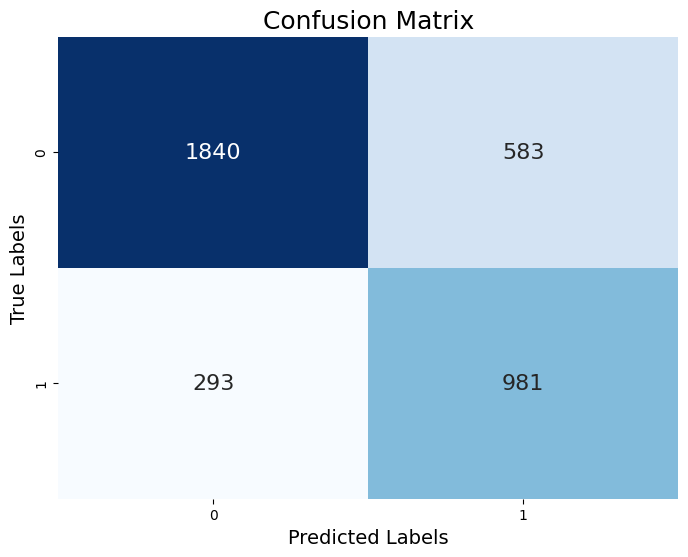


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      2423
           1       0.63      0.77      0.69      1274

    accuracy                           0.76      3697
   macro avg       0.74      0.76      0.75      3697
weighted avg       0.78      0.76      0.77      3697



In [ ]:
plot_confusion_matrix_classification_report(true_labels, predicted_labels)

## **Evaluation of Transfer Learning Model (DenseNet169) on Test Dataset**

* True Positives (TP): 981 (Correctly predicted abnormal cases)
* True Negatives (TN): 1840 (Correctly predicted normal cases)
* False Positives (FP): 583 (Normal cases predicted as abnormal)
* False Negatives (FN): 293 (Abnormal cases predicted as normal)

**Key Observations**

*Accuracy:*
* The overall accuracy is 76%, which is significantly higher than both previous models (V1 and V2).

* This indicates that transfer learning using DenseNet169 has significantly improved the model's generalization and robustness.

*Precision:*
* Class 0 (Normal): 0.86 - Excellent precision, meaning 86% of predicted normal cases are actually normal.

* Class 1 (Abnormal): 0.63 - Moderately good precision, but still leaves room for improvement.

* The model correctly identifies 63% of predicted abnormal cases as actually being abnormal.

*Recall:*
* Class 0 (Normal): 0.76 - The model correctly identifies 76% of actual normal cases.

* Class 1 (Abnormal): 0.77 - The model correctly identifies 77% of actual abnormal cases.

* The recall for abnormal cases (class 1) is notably better than previous models, indicating fewer false negatives.

*F1-Score:*
* Class 0 (Normal): 0.81 - High F1-score due to balanced precision and recall.

* Class 1 (Abnormal): 0.69 - Reasonably good F1-score, showing improvement in classifying abnormalities.

* The macro average F1-score of 0.75 indicates that the model balances both classes well.

In [ ]:
body_part_results = get_body_part_results(test_ds_for_evaluation, DenseNet_model)

Processing Batches:   0%|          | 0/116 [00:00<?, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


Processing Batches:   1%|          | 1/116 [00:41<1:18:36, 41.01s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Processing Batches:   2%|▏         | 2/116 [00:41<32:19, 17.02s/batch]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Batches:   3%|▎         | 3/116 [00:41<17:34,  9.33s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Batches:   3%|▎         | 4/116 [00:41<10:41,  5.73s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Batches:   4%|▍         | 5/116 [00:41<06:53,  3.73s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Batches:   5%|▌         | 6/116 [00:41<04:36,  2.52s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Batches:   6%|▌         | 7/116 [00:42<03:11,  1.76s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Batches:   7%|▋         | 8/116 [00:42<02:16,  1.26s/batch]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Batches:   8%|▊         | 9/116 [00:42<01:38,  1.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Batches:   9%|▊         | 10/116 [00:42<01:13,  1.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Batches:   9%|▉         | 11/116 [00:42<00:56,  1.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Batches:  10%|█         | 12/116 [00:43<00:45,  2.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Batches:  11%|█         | 13/116 [00:43<00:36,  2.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Batches:  12%|█▏        | 14/116 [00:43<00:31,  3.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Batches:  13%|█▎        | 15/116 [00:43<00:27,  3.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Batches:  14%|█▍        | 16/116 [00:43<00:25,  3.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Batches:  15%|█▍        | 17/116 [00:44<00:22,  4.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  16%|█▌        | 18/116 [00:44<00:20,  4.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  16%|█▋        | 19/116 [00:44<00:19,  5.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Batches:  17%|█▋        | 20/116 [00:44<00:17,  5.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Batches:  18%|█▊        | 21/116 [00:44<00:17,  5.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Batches:  19%|█▉        | 22/116 [00:44<00:16,  5.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Batches:  20%|█▉        | 23/116 [00:45<00:17,  5.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  21%|██        | 24/116 [00:45<00:16,  5.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Batches:  22%|██▏       | 25/116 [00:45<00:15,  5.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Batches:  22%|██▏       | 26/116 [00:45<00:15,  5.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Batches:  23%|██▎       | 27/116 [00:45<00:16,  5.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Batches:  24%|██▍       | 28/116 [00:45<00:16,  5.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Batches:  25%|██▌       | 29/116 [00:46<00:17,  4.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Batches:  26%|██▌       | 30/116 [00:46<00:17,  4.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Batches:  27%|██▋       | 31/116 [00:46<00:17,  4.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Batches:  28%|██▊       | 32/116 [00:46<00:17,  4.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Batches:  28%|██▊       | 33/116 [00:47<00:16,  5.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Batches:  29%|██▉       | 34/116 [00:47<00:17,  4.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Processing Batches:  30%|███       | 35/116 [00:47<00:17,  4.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Batches:  31%|███       | 36/116 [00:47<00:17,  4.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Batches:  32%|███▏      | 37/116 [00:47<00:17,  4.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Batches:  33%|███▎      | 38/116 [00:48<00:17,  4.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Processing Batches:  34%|███▎      | 39/116 [00:48<00:17,  4.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Batches:  34%|███▍      | 40/116 [00:48<00:17,  4.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Batches:  35%|███▌      | 41/116 [00:48<00:17,  4.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Batches:  36%|███▌      | 42/116 [00:49<00:15,  4.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Batches:  37%|███▋      | 43/116 [00:49<00:15,  4.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  38%|███▊      | 44/116 [00:49<00:14,  5.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Batches:  39%|███▉      | 45/116 [00:49<00:14,  4.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Batches:  40%|███▉      | 46/116 [00:49<00:13,  5.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Batches:  41%|████      | 47/116 [00:49<00:12,  5.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Batches:  41%|████▏     | 48/116 [00:50<00:12,  5.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Batches:  42%|████▏     | 49/116 [00:50<00:12,  5.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Batches:  43%|████▎     | 50/116 [00:50<00:11,  5.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  44%|████▍     | 51/116 [00:50<00:12,  5.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Batches:  45%|████▍     | 52/116 [00:50<00:11,  5.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  46%|████▌     | 53/116 [00:51<00:10,  5.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  47%|████▋     | 54/116 [00:51<00:11,  5.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Batches:  47%|████▋     | 55/116 [00:51<00:11,  5.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Batches:  48%|████▊     | 56/116 [00:51<00:11,  5.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  49%|████▉     | 57/116 [00:51<00:11,  5.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  50%|█████     | 58/116 [00:52<00:10,  5.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Batches:  51%|█████     | 59/116 [00:52<00:10,  5.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  52%|█████▏    | 60/116 [00:52<00:10,  5.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Batches:  53%|█████▎    | 61/116 [00:52<00:10,  5.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Batches:  53%|█████▎    | 62/116 [00:52<00:10,  5.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  54%|█████▍    | 63/116 [00:52<00:10,  5.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Batches:  55%|█████▌    | 64/116 [00:53<00:09,  5.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Batches:  56%|█████▌    | 65/116 [00:53<00:09,  5.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Batches:  57%|█████▋    | 66/116 [00:53<00:09,  5.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Batches:  58%|█████▊    | 67/116 [00:53<00:09,  5.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  59%|█████▊    | 68/116 [00:53<00:08,  5.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  59%|█████▉    | 69/116 [00:54<00:08,  5.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  60%|██████    | 70/116 [00:54<00:08,  5.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Batches:  61%|██████    | 71/116 [00:54<00:07,  5.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Batches:  62%|██████▏   | 72/116 [00:54<00:07,  5.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Batches:  63%|██████▎   | 73/116 [00:54<00:07,  5.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Batches:  64%|██████▍   | 74/116 [00:54<00:07,  5.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Batches:  65%|██████▍   | 75/116 [00:55<00:07,  5.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  66%|██████▌   | 76/116 [00:55<00:07,  5.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Batches:  66%|██████▋   | 77/116 [00:55<00:07,  5.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Batches:  67%|██████▋   | 78/116 [00:55<00:07,  5.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Batches:  68%|██████▊   | 79/116 [00:55<00:06,  5.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Batches:  69%|██████▉   | 80/116 [00:56<00:06,  5.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Batches:  70%|██████▉   | 81/116 [00:56<00:06,  5.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Batches:  71%|███████   | 82/116 [00:56<00:06,  5.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Batches:  72%|███████▏  | 83/116 [00:56<00:06,  5.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Batches:  72%|███████▏  | 84/116 [00:56<00:06,  4.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Processing Batches:  73%|███████▎  | 85/116 [00:57<00:06,  4.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Batches:  74%|███████▍  | 86/116 [00:57<00:06,  4.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Batches:  75%|███████▌  | 87/116 [00:57<00:06,  4.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Batches:  76%|███████▌  | 88/116 [00:57<00:06,  4.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Batches:  77%|███████▋  | 89/116 [00:57<00:05,  4.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Batches:  78%|███████▊  | 90/116 [00:58<00:05,  4.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Batches:  78%|███████▊  | 91/116 [00:58<00:05,  4.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Batches:  79%|███████▉  | 92/116 [00:58<00:05,  4.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Batches:  80%|████████  | 93/116 [00:58<00:05,  4.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Batches:  81%|████████  | 94/116 [00:59<00:06,  3.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Processing Batches:  82%|████████▏ | 95/116 [00:59<00:06,  3.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Processing Batches:  83%|████████▎ | 96/116 [00:59<00:06,  3.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Processing Batches:  84%|████████▎ | 97/116 [01:00<00:06,  3.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Processing Batches:  84%|████████▍ | 98/116 [01:00<00:05,  3.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Batches:  85%|████████▌ | 99/116 [01:00<00:04,  3.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Processing Batches:  86%|████████▌ | 100/116 [01:01<00:04,  3.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Batches:  87%|████████▋ | 101/116 [01:01<00:03,  3.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Batches:  88%|████████▊ | 102/116 [01:01<00:03,  4.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Batches:  89%|████████▉ | 103/116 [01:01<00:03,  4.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Processing Batches:  90%|████████▉ | 104/116 [01:02<00:02,  4.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Processing Batches:  91%|█████████ | 105/116 [01:02<00:02,  4.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Processing Batches:  91%|█████████▏| 106/116 [01:02<00:02,  4.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Batches:  92%|█████████▏| 107/116 [01:02<00:02,  4.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Batches:  93%|█████████▎| 108/116 [01:02<00:01,  4.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Batches:  94%|█████████▍| 109/116 [01:03<00:01,  4.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Batches:  95%|█████████▍| 110/116 [01:03<00:01,  5.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Batches:  96%|█████████▌| 111/116 [01:03<00:00,  5.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Batches:  97%|█████████▋| 112/116 [01:03<00:00,  5.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Batches:  97%|█████████▋| 113/116 [01:03<00:00,  5.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Batches:  98%|█████████▊| 114/116 [01:03<00:00,  5.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Batches:  99%|█████████▉| 115/116 [01:04<00:00,  5.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


Processing Batches: 100%|██████████| 116/116 [01:45<00:00,  1.10batch/s]


In [ ]:
print_body_parts(body_part_results)


Body Part: SHOULDER
Accuracy: 73.85%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       467
         1.0       0.74      0.71      0.72       443

    accuracy                           0.74       910
   macro avg       0.74      0.74      0.74       910
weighted avg       0.74      0.74      0.74       910


Body Part: HUMERUS
Accuracy: 75.97%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78        71
         1.0       0.74      0.72      0.73        58

    accuracy                           0.76       129
   macro avg       0.76      0.76      0.76       129
weighted avg       0.76      0.76      0.76       129


Body Part: FINGER
Accuracy: 73.70%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79       277
         1.0       0.75      0.56      0.64       202

  

## **Body Part-wise Performance Analysis (DenseNet169)**

**Key Observations and Insights**

***Accuracy Insights:***
* WRIST (78.62%)

* HAND (78.04%)

* ELBOW (77.83%)

* HUMERUS (75.97%)

The worst performing body part is FINGER (73.70%), but even that has significantly improved compared to previous models.

Overall, all body parts have improved accuracy, with most above 73%, indicating significant improvement over the custom CNN models.

***Precision and Recall Analysis:***

**Class 0 (Normal):**

* Precision for normal cases ranges from 0.70 to 0.80, with the highest in ELBOW (0.80) and HAND (0.79).

* Recall for normal cases is excellent across the board, ranging from 0.77 to 0.94.

* This shows that the model is particularly adept at identifying normal cases with high precision and recall.

**Class 1 (Abnormal):**

* Precision for abnormal cases ranges from 0.74 to 0.82, which is significantly better compared to previous models.

* Recall for abnormal cases is generally good, with most values around 0.60 to 0.72.

* The HAND body part has a relatively low recall (0.41) despite good precision, indicating that some abnormal hand X-rays are still being missed.

***F1-Score Analysis:***
* The F1-scores for both classes are significantly higher than in previous models.

* The F1-score for normal cases is consistently high across body parts, especially for WRIST (0.82) and ELBOW (0.83).

* The F1-score for abnormal cases is moderately high, with most scores in the range 0.67 to 0.73.

* The improvement in F1-score indicates a better balance between precision and recall.

## **Conclusion**

The DenseNet169 model has significantly outperformed both custom CNN models (V1 and V2), achieving superior accuracy and balanced performance across all body parts. Transfer learning with DenseNet169 has proven to be a robust approach for X-ray classification, effectively capturing intricate patterns and achieving high accuracy, especially for problematic body parts.